
#  高性能プログラミングと性能測定(2) --- OpenMP GPUプログラミング


# 1. OpenMP の GPU 向け拡張
* OpenMPの最近の仕様ではGPUもサポートしている(どこまでサポートしているかはコンパイラ依存)

* 詳しい仕様が知りたくなったら https://openmp.org/ を参照
  * 最新仕様 https://www.openmp.org/spec-html/5.2/openmp.html
  * 簡潔な文法のリファレンス: https://www.openmp.org/resources/refguides/
* 最小限の覚えるべきキーワード
  * 既出: マルチコアCPUでも必要だったもの
    * `#pragma omp parallel`
    * `#pragma omp for` 
    * `reduction`
  * 今回: GPUで必要になるもの --- どれも「実は」マルチコアCPUでも使える. マルチコアCPUだけを使う分には不要
    * `#pragma omp target` (実行をGPUに移動)
    * `#pragma omp teams` ($\approx$ `parallel`)
    * `#pragma omp distribute` ($\approx$ `for`)
    * `#pragma omp loop` ($\approx$ `for`, `distribute`)

* 最小限の覚えるべきAPI関数
```
#include <omp.h> 
```
して
  * 既出: マルチコアCPUでも必要だったもの
    * omp_get_num_threads();
    * omp_get_thread_num();
  * 今回: GPUで必要になるもの
    * omp_get_num_teamss();
    * omp_get_team_num();

* うまくするとCPUとGPUで同じソースコードで動くプログラムを書くことも可能

* 有益なスライド
  * [Swaroop Pophale](https://www.olcf.ornl.gov/wp-content/uploads/2021/08/ITOpenMP_Day1.pdf)
  * [Jeff Larkin](https://openmpcon.org/wp-content/uploads/openmpcon2021-nvidia.pdf)


# 2. コンパイラ (NVIDIA HPC SDK)
* コマンド名:
  * C: `nvc`
  * C++: `nvc++`
* コンパイルオプション:
  * `-mp=gpu` をつけると GPU用のOpenMPがサポートされる
  * `-mp=multicore` をつけると CPU用のOpenMPがサポートされる
* 上記のコマンドを実行できるようにするために, 以下を実行してください(この環境特有. Wisteriaでは別のやり方(moduleコマンド))

In [ ]:
export PATH=/opt/nvidia/hpc_sdk/Linux_x86_64/24.5/compilers/bin:$PATH

* 演習環境には taulec.zapto.org と tauleg.zapto.org があるが, GPUのコードを動かせるのは後者

In [ ]:
hostname
hostname | grep tauleg || echo "Oh, you are not on the right host, access https://tauleg000.zapto.org/ instead"

# 3. 重要な pragma
* [`#pragma omp target`](https://www.openmp.org/spec-html/5.0/openmpsu60.html#x86-2820002.12.5) : 実行を **デバイス(GPU)** に移す
* [`#pragma omp teams`](https://www.openmp.org/spec-html/5.0/openmpse15.html#x57-910002.7) : デバイス上に**チーム**を多数作成する ($\approx$ `#pragma omp parallel`)
* [`#pragma omp distribute`](https://www.openmp.org/spec-html/5.0/openmpsu43.html#x66-1580002.9.4) : 繰り返しをチーム間で分割実行する ($\approx$ `#pragma omp for`)
* [`#pragma omp parallel`](https://www.openmp.org/spec-html/5.0/openmpse14.html#x54-800002.6) : チーム内に**スレッド**を多数作成する
* [`#pragma omp for`](https://www.openmp.org/spec-html/5.0/openmpsu41.html#x64-1290002.9.2) : 繰り返しをチームのスレッドに分割実行する
* [`#pragma omp target data`](https://www.openmp.org/spec-html/5.0/openmpsu57.html#x83-2580002.12.2) : ホストCPUとデバイス(GPU)間のデータをマッピングする



# 4. [`#pragma omp target`](https://www.openmp.org/spec-html/5.0/openmpsu60.html) $\sim$ 実行をデバイス(GPU)に移す
* <font color="blue">構文</font>
```
#pragma omp target
    S
```
* $S$は文 (以降いちいち断らない)
* $S$ をデバイス (通常はGPU) で実行 (にオフロード) する 

In [ ]:
%%writefile omp_target.c
#include <stdio.h>
int main() {
  printf("hello on host\n");
#pragma omp target
  printf("hello from target (hopefully GPU)\n");
  printf("back on host\n");
  return 0;
}

* コンパイル

In [ ]:
nvc -mp=gpu omp_target.c -o omp_target_gpu.exe


* 実行

In [ ]:
./omp_target_gpu.exe


* 注:
  * `target` は通常GPUを使用することを意図して使うが、実際にはGPUがなくても実行できる (CPUにフォールバック実行)
  * 上記のプログラムを実行すると、マシンにGPUがあるかどうかに関係なく同じ結果が得られる
    * `printf` はどちらで実行しても同じなので当然
  * プログラムの移植性のためには良いが、GPUで実行しているつもりが実はCPUなどということがあるとかえって混乱を招く可能性がある
  * GPUが利用できなければエラーを発生させることもできる. それには、環境変数 `OMP_TARGET_OFFLOAD=MANDATORY` を設定する。逆に、`OMP_TARGET_OFFLOAD=DISABLED` はその反対の効果を持つ

In [ ]:
# GPUで実行することを強制. できなければエラー
OMP_TARGET_OFFLOAD=MANDATORY ./omp_target_gpu.exe

In [ ]:
# ホストで実行することを強制
OMP_TARGET_OFFLOAD=DISABLED ./omp_target_gpu.exe


# 5. [`#pragma omp teams`](https://www.openmp.org/spec-html/5.0/openmpse15.html#x57-910002.7) $\sim$ チームの作成
## 5-1. 基本
* <font color="blue">構文</font>
```
#pragma omp target
#pragma omp teams
    S
```
複数のチームを作成し、各チームの*マスター*が $S$ を実行する

* `#pragma omp parallel` に似ており、多くのスレッドが同じ文を実行する効果を持つ
* `teams` は `parallel` の外側にある追加の並列化レイヤーと考えればよい
  * `teams` はチームを多数作る
  * `parallel` は各チーム内でスレッドを多数作る
* 実はマルチコアCPUでは初めからチームがひとつできており, そのマスターが `main` 関数を実行するスレッドだったと考えれば良い


In [ ]:
%%writefile omp_teams.c
#include <stdio.h>
int main() {
  printf("hello on host\n");
#pragma omp target
#pragma omp teams
  printf("hello, I am the master of a team\n");
  printf("back on host\n");
  return 0;
}

In [ ]:
nvc -mp=gpu omp_teams.c -o omp_teams_gpu.exe

In [ ]:
./omp_teams_gpu.exe


* 注:
  * `teams` は `target` のすぐ内側に現れる必要がある
  * そのため実際、`target` と `teams` はしばしば一行で使用される (`#pragma omp target teams`)
  * つまり次の形が普通


In [ ]:
%%writefile omp_target_teams.c
#include <stdio.h>
int main() {
  printf("hello on host\n");
#pragma omp target teams
  printf("hello, I am the master of a team\n");
  printf("back on host\n");
  return 0;
}

In [ ]:
nvc -mp=gpu omp_target_teams.c -o omp_target_teams_gpu.exe

In [ ]:
./omp_target_teams_gpu.exe

## 5-2. チームの数を指定する
* `teams` 構文で作成されるチームの数を $x$ に設定するには、以下のいずれかの方法がある
  * `teams` 構文に `num_teams(x)` を追加 (`parallel` 構文の `num_threads` と類似)
  * コマンド実行時に `OMP_NUM_TEAMS=x` 環境変数を設定 (`OMP_NUM_THREADS` と類似)

In [ ]:
OMP_NUM_TEAMS=3 ./omp_teams_gpu.exe

* 上記の3を色々変えて実行してみよ


## 5-3. チームIDとチーム数の取得
* `omp_get_thread_num()` と `omp_get_num_threads()` がスレッドIDとスレッド数を取得するのと同様に、チームIDとチーム数を取得できる
  * `omp_get_team_num()`
  * `omp_get_num_teams()` 

In [ ]:
%%writefile omp_team_num.c
#include <stdio.h>
#include <omp.h>
int main() {
  printf("hello on host\n");
#pragma omp target
#pragma omp teams
  printf("in teams: %03d/%03d\n", omp_get_team_num(), omp_get_num_teams());
  printf("back on host\n");
  return 0;
}

In [ ]:
nvc -mp=gpu omp_team_num.c -o omp_team_num_gpu.exe


* 実行

In [ ]:
OMP_NUM_TEAMS=5 ./omp_team_num_gpu.exe


* `OMP_NUM_TEAMS` を設定せずに実行

In [ ]:
./omp_team_num_gpu.exe


* 108のチームが作られる
* それはこの環境のGPU (NVIDIA A100)に備わる「コア」の数である
* マルチコア環境で`OMP_NUM_THREADS`を指定せずに`#pragma omp parallel`を実行したときにコア数だけのスレッドが作られるのと似ている
* なおNVIDIA GPUでは普通のCPUで言うところの「コア」を「Streaming Multiprocessor」と呼ぶ
* つまり `OMP_NUM_TEAMS` や `num_teams` による指定を省略すると, (仕様上そう定められているかは知らないが普通), Streaming Multiprocessorの数だけのチームが作られる
* そしてこの環境やWisteriaに搭載されているNVIDIA A100 GPUは108 のStreaming Multiprocessor を備えているということ
* なおこれは特段驚くような多さではなく, CPUでもサーバー用ではこのくらいのコア数を持つものがある



# 6. [`#pragma omp distribute`](https://www.openmp.org/spec-html/5.0/openmpsu43.html#x66-1580002.9.4) $\sim$ for文の繰り返しをチーム間で分割実行
* <font color="blue">構文</font>
```
#pragma omp target
#pragma omp teams
    {
      ...
#pragma omp distribute
      for (...) {
        ...
      }
    }
```
for文の繰り返しをチームに分配する

* `distribute` の直下に書けるfor文には, `parallel` の下に書けるfor文と同じ制限 (breakできない, など)が有る
* だいたい,
  * `#pragma omp teams` $\approx$ `#pragma omp parallel` 
  * `#pragma omp distribute` $\approx$ `#pragma omp for`
と思っておけばよい


In [ ]:
%%writefile omp_distribute.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
int main(int argc, char ** argv) {
  int i = 1;
  int m = (argc > i ? atoi(argv[i]) : 5); i++;
  printf("hello on host\n");
#pragma omp target
#pragma omp teams
  {
    printf("in teams: %03d/%03d\n", omp_get_team_num(), omp_get_num_teams());
#pragma omp distribute
    for (int i = 0; i < m; i++) {
      printf("in distribute: i=%03d executed by %03d/%03d\n",
             i, omp_get_team_num(), omp_get_num_teams());
    }
  }
  printf("back on host\n");
  return 0;
}

In [ ]:
nvc -mp=gpu omp_distribute.c -o omp_distribute_gpu.exe


* 異なるチーム数とコマンドラインの繰り返し回数で次のコマンドを実行し、その結果を理解せよ

In [ ]:
OMP_NUM_TEAMS=3 ./omp_distribute_gpu.exe 5


# <font color="green"> Problem 1 :  teams と distribute を理解する</font>
* 後々混乱しないように簡単なクイズ
* 上記のプログラムを <font color="blue"><tt>OMP_NUM_TEAMS=$T$ ./omp_distribute_gpu.exe $m$</tt></font> で実行したときに、どの行が何スレッドによって実行されるか(何が何回表示されるか)を推測し、その結果、何行が出力されるかを, 
* $T$ と $m$ の式で答えよ

BEGIN SOLUTION
END SOLUTION

* 答えを確認するために、以下のように `wc` コマンドを使用して行数を数えればよい(左端の数字が行数)

* 次のコマンドを異なるチーム数とコマンドラインの繰り返し回数で実行せよ

In [ ]:
OMP_NUM_TEAMS=3 ./omp_distribute_gpu.exe 5 | wc -l


* 注:
  * `teams` と `distribute` の間に何も文がなければ、1つの指示 (`#pragma omp teams distribute`)で書ける (`parallel` と `for` でできたのと同じ)
  * `target` と `teams` を結合できた, ということで, 3つを1つの指示に結合できる

In [ ]:
%%writefile omp_target_teams_distribute.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
int main(int argc, char ** argv) {
  int i = 1;
  int m = (argc > i ? atoi(argv[i]) : 5);
  printf("hello on host\n");
#pragma omp target teams distribute
  for (int i = 0; i < m; i++) {
    printf("in distribute: i=%03d executed by %03d/%03d\n",
           i, omp_get_team_num(), omp_get_num_teams());
  }
  printf("back on host\n");
  return 0;
}

In [ ]:
nvc -mp=gpu omp_target_teams_distribute.c -o omp_target_teams_distribute_gpu.exe

In [ ]:
OMP_NUM_TEAMS=3 ./omp_target_teams_distribute_gpu.exe 7


* 見ての通り `teams` と `distribute` だけで `parallel` や `for` を使わずにループを並列化できる
* それで起こることはGPUの**各コア (Streaming Multiprocessor) で1つ**のスレッドが実行するということである
* CPUのコアはもともと1つのスレッドを実行するものだがGPUのStreaming Multiprocessorはそうではなく, 1つのコア内に多数のスレッドを実行する能力を持つ(逆に1スレッドの性能はCPUよりも遅い)
* `parallel` を使用すると各チーム内にスレッドが作られ, 結果的に各Streaming Multiprocessor内で多数のスレッドを動かすことになる
* 注: CPUは1コア内に1スレッド以上を動かすことはできない代わりに, SIMD命令と, 命令レベル並列性というものを使って**1スレッドの**性能を向上させることができる


# 7. [`#pragma omp parallel`](https://www.openmp.org/spec-html/5.0/openmpse14.html#x54-800002.6) $\sim$ チーム内でのスレッドの作成
## 7-1. `teams` 内の `parallel`
* 構文:
```
#pragma omp target
#pragma omp teams
    {
      ...
#pragma omp parallel
      S
    }
```
各チーム内でスレッドを作成する

* `teams` 内で使用すると、**各チーム**内でスレッドを作成し、それぞれが $S$ を実行する

* 例として、<font color="blue"><tt>OMP_NUM_TEAMS=$T$ OMP_NUM_THREADS=$H$ ./omp_team_parallel_gpu.exe</tt></font> は $T$ チームを作成し、それぞれが $H$ スレッドを作成する

In [ ]:
%%writefile omp_parallel.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
int main(int argc, char ** argv) {
  char * nthreads_ = getenv("OMP_NUM_THREADS");
  int    nthreads  = (nthreads_ ? atoi(nthreads_) : 1);
  if (nthreads % 32) {
    fprintf(stderr, "OMP_NUM_THREADS (%d) must be a multiple of 32\n", nthreads);
    exit(1);
  }
  printf("hello on host\n");
#pragma omp target teams
  {
    printf("in teams: %03d/%03d\n", omp_get_team_num(), omp_get_num_teams());
#pragma omp parallel num_threads(nthreads)
    printf("in parallel: %03d/%03d %03d/%03d\n",
           omp_get_team_num(), omp_get_num_teams(),
           omp_get_thread_num(), omp_get_num_threads());
  }
  printf("back on host\n");
  return 0;
}

In [ ]:
nvc -mp=gpu omp_parallel.c -o omp_parallel_gpu.exe

In [ ]:
OMP_NUM_TEAMS=3 OMP_NUM_THREADS=32 ./omp_parallel_gpu.exe


* マルチコアCPUでもスレッドを作成するために `parallel` を使用したことを思い出そう
* ただし`teams` は不要だった
* これはマルチコアCPU環境では、全体が一つのチームだったと考えれば辻褄が合う
* 実はCPUであっても, `#pragma target teams` をつけても害はない
* 1つチームが作られ, その後`#pragma omp parallel`でその一つのチーム内にスレッドが作られるという動作になる

* <font color="red">重要な注意1: GPUではOMP_NUM_THREADS は効き目がない</font>模様
  * CPUでは、`parallel` によって作成されるスレッド数は `OMP_NUM_THREADS=x` 環境変数や `parallel` 指令の `num_threads(x)` で指定できた
  * しかし、GPUで実行する場合はこれができない模様 (実装の問題か仕様の問題かは不明)
  * 設定する必要がある場合は、`num_threads(x)` を使用する必要がある
    * 上記のプログラムでは環境変数を(`getenv`で)読んで`num_threads(x)` に渡している
  * または省略してシステムに任せる
* <font color="red">重要な注意2: スレッド数は32の倍数でなければならない</font>模様
  * 詳しくは省略するがGPUのハードウェアの仕組み(32スレッドからなるwarpという単位で同時に実行する)を考えると頷ける動作
  * そうでない数を設定してもエラーも発生しないため, くれぐれも誤った数を指定しないように注意する必要がある
  * 特に必要ない限りシステムに任せるのが無難



# <font color="green"> Problem 2 :  teamsとparallelを理解する</font>
* `teams`と`parallel`の組み合わせに関するクイズ
* 上記のプログラムを <font color="blue"><tt>OMP_NUM_TEAMS=$T$ OMP_NUM_THREADS=$H$ ./omp_parallel_gpu.exe</tt></font> で実行したときに、どの行が何スレッドによって実行されるかを推測し、その結果、何行が出力されるかを表現します
* 答えを $T$ と $H$ の式で答えよ

BEGIN SOLUTION
END SOLUTION

* 答えを簡単に確認するために、`wc` コマンドを使用して行数を数えよ

In [ ]:
OMP_NUM_TEAMS=3 OMP_NUM_THREADS=32 ./omp_parallel_gpu.exe | wc -l


## 7-2. `teams` 内の `distribute` 内の `parallel`
* 典型的には、`parallel` は `distribute` 内 (必然的に `teams` 内) で呼び出す
* 以下は構文的には新しいことは何もない


In [ ]:
%%writefile omp_distribute_parallel.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
int main(int argc, char ** argv) {
  char * nthreads_ = getenv("OMP_NUM_THREADS");
  int    nthreads  = (nthreads_ ? atoi(nthreads_) : 1);
  if (nthreads % 32) {
    fprintf(stderr, "OMP_NUM_THREADS (%d) must be a multiple of 32\n", nthreads);
    exit(1);
  }
  int m = (argc > 1 ? atoi(argv[1]) : 5);
  printf("hello on host\n");
#pragma omp target teams
  {
    printf("in teams: %03d/%03d\n", omp_get_team_num(), omp_get_num_teams());
#pragma omp distribute
    for (int i = 0; i < m; i++) {
      printf("in distribute: i=%03d executed by %03d/%03d\n",
             i, omp_get_team_num(), omp_get_num_teams());
#pragma omp parallel num_threads(nthreads)
      printf("in parallel: i=%03d %03d/%03d %03d/%03d\n",
             i, omp_get_team_num(), omp_get_num_teams(),
             omp_get_thread_num(), omp_get_num_threads());
    }
  }
  printf("back on host\n");
  return 0;
}

In [ ]:
nvc -mp=gpu omp_distribute_parallel.c -o omp_distribute_parallel_gpu.exe

In [ ]:
OMP_NUM_TEAMS=3 OMP_NUM_THREADS=32 ./omp_distribute_parallel_gpu.exe 5


# <font color="green"> Problem 3 :  teams, distribute, parallelを理解する</font>
* team, distribute, parallelの組み合わせに関するクイズ
* 上記のプログラムを <font color="blue"><tt>OMP_NUM_TEAMS=$T$ OMP_NUM_THREADS=$H$ ./omp_distribute_parallel_gpu.exe $m$</tt></font> で実行したときに、どの行が何スレッドによって実行されるかを推測し、その結果、何行が出力されるかを式で表せ
* $T$, $H$, $m$ の式で答えよ

BEGIN SOLUTION
END SOLUTION

* 答えを簡単に確認するために、`wc` コマンドを使用して行数を数えよ

In [ ]:
OMP_NUM_TEAMS=3 OMP_NUM_THREADS=32 ./omp_distribute_parallel_gpu.exe 5 | wc -l


# 8. [`#pragma omp for`](https://www.openmp.org/spec-html/5.0/openmpsu41.html#x64-1290002.9.2) $\sim$ for文の繰り返しをスレッド間で分割実行
* 構文:
```
#pragma omp target
#pragma omp teams
    ...
#pragma omp distribute
#pragma omp parallel
    ...
#pragma omp for
for (...) {
    ...
}  
```

* `parallel` 内で使用されると、ループの繰り返しをスレッドに分配する


In [ ]:
%%writefile omp_for.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
int main(int argc, char ** argv) {
  char * nthreads_ = getenv("OMP_NUM_THREADS");
  int    nthreads  = (nthreads_ ? atoi(nthreads_) : 1);
  if (nthreads % 32) {
    fprintf(stderr, "OMP_NUM_THREADS (%d) must be a multiple of 32\n", nthreads);
    exit(1);
  }
  int m = (argc > 1 ? atoi(argv[1]) : 5);
  int n = (argc > 2 ? atoi(argv[2]) : 6);
  printf("hello on host\n");
#pragma omp target teams
  {
    printf("in teams: %03d/%03d\n", omp_get_team_num(), omp_get_num_teams());
#pragma omp distribute
    for (int i = 0; i < m; i++) {
      printf("in distribute: i=%03d executed by %03d/%03d\n",
             i, omp_get_team_num(), omp_get_num_teams());
#pragma omp parallel num_threads(nthreads)
      printf("in parallel: i=%03d %03d/%03d %03d/%03d\n",
             i, omp_get_team_num(), omp_get_num_teams(),
             omp_get_thread_num(), omp_get_num_threads());
#pragma omp for
      for (int j = 0; j < n; j++) {
        printf("in for: i=%03d j=%03d executed by %03d/%03d %03d/%03d\n",
               i, j, omp_get_team_num(), omp_get_num_teams(),
               omp_get_thread_num(), omp_get_num_threads());
      }
    }
  }
  printf("back on host\n");
  return 0;
}

In [ ]:
nvc -mp=gpu omp_for.c -o omp_for_gpu.exe

In [ ]:
OMP_NUM_TEAMS=3 OMP_NUM_THREADS=32 ./omp_for_gpu.exe 5 6


# <font color="green"> Problem 4 :  teams, distributed, paralle, for を理解する</font>
* teams, distributed, paralle, for の組み合わせに関するクイズ
* 上記のプログラムを <font color="blue"><tt>OMP_NUM_TEAMS=$T$ OMP_NUM_THREADS=$H$ ./omp_for_gpu.exe $m$ $n$</tt></font> で実行したときに、どの行が何スレッドによって実行されるかを推測し、その結果、何行が出力されるかを式で洗わせ
* $T$, $H$, $m$, $n$ の式で表せ
* 答えを簡単に確認するために、`wc` コマンドを使用して行数を数えよ

In [ ]:
OMP_NUM_TEAMS=3 OMP_NUM_THREADS=32 ./omp_for_gpu.exe 5 6 | wc -l


# 9. よく出てくるディレクティブの結合
* 論理的な一貫性のない多くの異なる指示の名前にうんざりすることだろう
* それぞれは名目上は独立した指示ですが、実際にはほとんど常に一緒に使用される
* 多くの場合, 目的はループを並列に実行することなので、以下の形式のいずれかで使用されることが多い

1\. すべてを結合
```
#pragma omp target teams distribute parallel for
    for (...) {
      ...
    }
```
2\. 外側のループを `teams` と `distribute` で並列化し、内側のループを `parallel` と `for` で並列化する

```
#pragma omp target teams distribute
    for (...) {
#pragma omp parallel for
      for (...) {
        ...
      }
    }  
```



# 10. [`#pragma omp target data`](https://www.openmp.org/spec-html/5.0/openmpsu57.html#x83-2580002.12.2) $\sim$ ホストCPUとGPU間のデータをマッピングする
* GPUはCPUと異なるメモリを持っていて, (CPU内のコアと異なり)メモリをハードウェア的に共有しているわけではない(実は最近この事情は変わりつつあるが, 少なくともこの環境やWisteriaはそうではない)
* したがってある計算をGPU上で行おうと思ったら一般にはその計算が必要とするデータをGPUに送ってから実行する必要がある
* 逆にGPU上で得た結果をCPUで使いたければ, GPUが計算した結果をCPUに送る必要がある
* `target data` とその `map` 節は、それらのデータ転送を手軽に行う指示である

* <font color="red">警告：</font> [仕様書](https://www.openmp.org/spec-html/5.0/openmpsu109.html#x142-6180002.19.7)は法律のようなわかりにくさ
* 以下はより直截で, 普通の日本語で説明を試みているが、一部は仕様書で裏を取らず, 実際の実験や実装が行っているであろうことの想像に基づいて書かれている

* <font color="blue">構文：</font>
```
#pragma omp target data map(to: ...) map(from: ...) map(tofrom: ...) ...
    S
```
ここで、... は変数、配列名、または基底アドレス + 範囲 (例: a[0:n])など

* これらの節は指定された変数、配列、またはアドレス範囲が $S$ の間または後に「期待される」値を持つという効果をもたらす
* より具体的には、
  * `map(to: ...)` に指定されたものは $S$ の間GPU上で有効になります
  * `map(from: ...)` に指定されたものは $S$ の後CPU上で有効になります
* これを達成するために、実行時システムによってCPUアドレスとGPUアドレス間の <font color="blue">_マッピング_</font> が維持され、必要に応じて内容がCPU-GPU間で移動する(コピーされる)
  * `map(to: ...)` に指定されたデータは $S$ の前に必要ならばGPUにコピーされる (CPU -> GPU)
  * `map(from: ...)` に指定されたデータは $S$ の後に必要ならばGPUからコピーされる (GPU -> CPU)
  * `map(tofrom: ...)` は両方の効果を持つ
* `map` 節を指定しなくても同じ効果を持つこともある(が, どういうときにそうなるかを仕様書から理解しようとするよりも, 指定するほうが早い)

* 通常、このディレクティブは `#pragma omp target` と一緒に使用され、実際にこれらの節を `#pragma omp target` に指定することもできる



## 10-1. ローカル変数と配列
* 以下のプログラムを実行してどの変数がGPUで利用可能か観察せよ


In [ ]:
%%writefile omp_map_local.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
typedef struct { float x; float y; } point;
int main(int argc, char ** argv) {
  int i = 1;
  float t = (argc > i ? atof(argv[i]) : 10.0); i++;
  float a[3] = { t, t + 1, t + 2 };
  point p = { t + 3, t + 4 };
  // you do not have to explicitly say anything about t, a, or p.
  // they are automatically available on GPU
#pragma omp target
  {
    printf("GPU: t = %f\n", t);
    printf("GPU: a = { %f, %f, %f }\n", a[0], a[1], a[2]);
    printf("GPU: p = { %f, %f }\n", p.x, p.y);
    t *= 2.0;
    for (int i = 0; i < 3; i++) a[i] *= 2.0;
    p.x *= 2.0; p.y *= 2.0;
  }
  printf("CPU: t = %f\n", t);
  printf("CPU: a = { %f, %f, %f }\n", a[0], a[1], a[2]);
  printf("CPU: p = { %f, %f }\n", p.x, p.y);
  return 0;
}

In [ ]:
nvc -mp=gpu omp_map_local.c -o omp_map_local_gpu.exe

In [ ]:
./omp_map_local_gpu.exe


# <font color="green"> Problem 5 :  `map(from: ..)` または `map(tofrom: ..)` の利用</font>
* CPUがすべての結果(`t, a, p`にGPUが書き込んだ値)を取得(正しく表示)できるよう, 適切な `map` 節を追加せよ


In [ ]:
%%writefile omp_map_local.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
typedef struct { float x; float y; } point;
int main(int argc, char ** argv) {
  int i = 1;
  float t = (argc > i ? atof(argv[i]) : 10.0); i++;
  float a[3] = { t, t + 1, t + 2 };
  point p = { t + 3, t + 4 };
  // you do not have to explicitly say anything about t, a, or p.
  // they are automatically available on GPU
#pragma omp target
  {
    printf("GPU: t = %f\n", t);
    printf("GPU: a = { %f, %f, %f }\n", a[0], a[1], a[2]);
    printf("GPU: p = { %f, %f }\n", p.x, p.y);
    t *= 2.0;
    for (int i = 0; i < 3; i++) a[i] *= 2.0;
    p.x *= 2.0; p.y *= 2.0;
  }
  printf("CPU: t = %f\n", t);
  printf("CPU: a = { %f, %f, %f }\n", a[0], a[1], a[2]);
  printf("CPU: p = { %f, %f }\n", p.x, p.y);
  return 0;
}

In [ ]:
nvc -mp=gpu omp_map_local.c -o omp_map_local_gpu.exe

In [ ]:
./omp_map_local_gpu.exe


## 10-2. グローバル変数と配列
* 先と同様, 以下のプログラムを実行してどの変数がGPUで利用可能か観察せよ


In [ ]:
%%writefile omp_map_global.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
typedef struct { float x; float y; } point;
float t;
float a[3];
point p;
int main(int argc, char ** argv) {
  int i = 1;
  t = (argc > i ? atof(argv[i]) : 10.0); i++;
  for (int i = 0; i < 3; i++) { a[i] = t + i; }
  p.x = t + 3; p.y = t + 4;
#pragma omp target
  {
    printf("GPU: t = %f\n", t);
    printf("GPU: a = { %f, %f, %f }\n", a[0], a[1], a[2]);
    printf("GPU: p = { %f, %f }\n", p.x, p.y);
    t *= 2.0;
    for (int i = 0; i < 3; i++) a[i] *= 2.0;
    p.x *= 2.0; p.y *= 2.0;
  }
  printf("CPU: t = %f\n", t);
  printf("CPU: a = { %f, %f, %f }\n", a[0], a[1], a[2]);
  printf("CPU: p = { %f, %f }\n", p.x, p.y);
  return 0;
}

In [ ]:
nvc -mp=gpu omp_map_global.c -o omp_map_global_gpu.exe

In [ ]:
./omp_map_global_gpu.exe


# <font color="green"> Problem 6 :  `map(from: ..)` または `map(tofrom: ..)` の利用</font>
* CPUがすべての結果(`t, a, p`にGPUが書き込んだ値)を取得(正しく表示)できるよう, 適切な `map` 節を追加せよ


In [ ]:
%%writefile omp_map_global.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
typedef struct { float x; float y; } point;
float t;
float a[3];
point p;
int main(int argc, char ** argv) {
  int i = 1;
  t = (argc > i ? atof(argv[i]) : 10.0); i++;
  for (int i = 0; i < 3; i++) { a[i] = t + i; }
  p.x = t + 3; p.y = t + 4;
#pragma omp target
  {
    printf("GPU: t = %f\n", t);
    printf("GPU: a = { %f, %f, %f }\n", a[0], a[1], a[2]);
    printf("GPU: p = { %f, %f }\n", p.x, p.y);
    t *= 2.0;
    for (int i = 0; i < 3; i++) a[i] *= 2.0;
    p.x *= 2.0; p.y *= 2.0;
  }
  printf("CPU: t = %f\n", t);
  printf("CPU: a = { %f, %f, %f }\n", a[0], a[1], a[2]);
  printf("CPU: p = { %f, %f }\n", p.x, p.y);
  return 0;
}

In [ ]:
nvc -mp=gpu omp_map_global.c -o omp_map_global_gpu.exe

In [ ]:
./omp_map_global_gpu.exe


# 11. 台数効果の目撃
* CPUのときと同様, スレッド数(+ チーム数)を増やして性能向上を確認しよう


In [ ]:
%%writefile omp_speedup.c
#include <assert.h>
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <omp.h>
#include <time.h>
#include <unistd.h>

/* x = ax + b をひたすら n 回繰り返す.
   (|a| < 1.0 なら c によらず, x = b / (1 - a) に収束).
   n 回 mul + add を行う (-> 2 n flops) */
double lin_rec(double a, double b, double c, long n) {
  double x = c;
  for (long j = 0; j < n; j++) {
    x = a * x + b;
  }
  return x;
}

int main(int argc, char ** argv) {
  char * nteams_   = getenv("OMP_NUM_TEAMS");
  int    nteams    = (nteams_   ? atoi(nteams_) : 1);
  char * nthreads_ = getenv("OMP_NUM_THREADS");
  int    nthreads  = (nthreads_ ? atoi(nthreads_) : 1);
  long m           = (1 < argc ? atol(argv[1]) : nteams * nthreads);
  long n           = (2 < argc ? atol(argv[2]) : 100 * 1000 * 1000);
  double * x = (double *)calloc(sizeof(double), m);
  assert(x);
  printf("num_teams = %ld, num_threads = %ld\n", nteams, nthreads);
  printf("m = %ld, n = %ld\n", m, n);
  /* 計測開始 */
  double t0 = omp_get_wtime();
  /* 計算本体 */
#pragma omp target teams distribute parallel for num_teams(nteams) num_threads(nthreads) map(tofrom: x[0:m])
  for (long i = 0; i < m; i++) {
    x[i] = lin_rec(0.99, i + 1, 1.0, n);
  }
  /* 計測終了 */
  double t1 = omp_get_wtime();
  double dt = t1 - t0;          /* sec */
  
  /* 答え表示 (x[i] = 100 * (i + 1) くらいのはず) */
  long err = 0;
  for (long i = 0; i < m; i++) {
    if (fabs(x[i] - 100 * (i + 1)) > 1.0e-3) {
      printf("x[%3ld] = %9.3f\n", i, x[i]);
      err++;
    }
  }
  if (err == 0) {
    printf("OK\n");
  }
  double flops = 2. * (double)m * (double)n;
  printf("elapsed    : %7.3f  sec\n", dt);
  printf("elapsed/m  : %7.3f msec\n", dt / m * 1e3);
  printf("elapsed/n  : %7.3f nsec\n", dt / n * 1e9);
  printf("elapsed/mn : %7.3f nsec\n", dt / (m * n) * 1e9);
  printf("flops      : %.2e\n", flops);
  printf("%.3f GFLOPS\n", flops / dt * 1e-9);
  return 0;
}


In [ ]:
nvc -fast -mp=gpu omp_speedup.c -o omp_speedup_gpu.exe

```
OMP_NUM_TEAMS=nteams OMP_NUM_THREADS=nthreads ./omp_speedup_gpu.exe m n
```
* とすると, チーム数=`nteams`, スレッド数=`nthreads` で実行する
* `m`, `n` は省略すると, `m` = `nteams` $\times$ `nthreads` とする
* まず, `nteams=1` として, `nthreads` だけを変えて, 性能向上を確認せよ
* `OMP_NUM_THREADS` は1でなければ, 32の倍数でないといけないことに注意

In [ ]:
OMP_NUM_TEAMS=1 OMP_NUM_THREADS=1 ./omp_speedup_gpu.exe

* 手動でやるのが嫌になったら以下で一撃で実行

In [234]:
for th in 1 32 64 96 128 160 192 224 256 384 512 640 768 896 1024 ; do
    echo -n "$th "
    OMP_NUM_TEAMS=1 OMP_NUM_THREADS=${th} ./omp_speedup_gpu.exe | grep GFLOPS
done

1 0.280 GFLOPS
32 10.432 GFLOPS
64 21.049 GFLOPS
96 31.283 GFLOPS
128 42.029 GFLOPS
160 42.828 GFLOPS
192 51.528 GFLOPS
224 59.844 GFLOPS
256 68.452 GFLOPS
384 75.866 GFLOPS
512 79.073 GFLOPS
640 80.821 GFLOPS
768 81.988 GFLOPS
896 83.171 GFLOPS
1024 83.812 GFLOPS


* 結果を以下で可視化 (上の結果をコピペせよ)

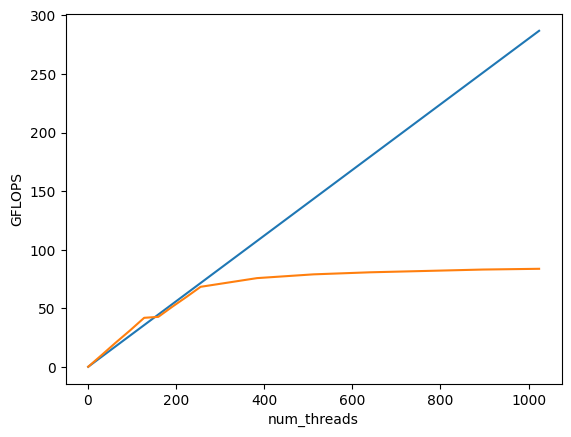

In [235]:
import matplotlib.pyplot as plt

DATA = r"""
1 0.280 GFLOPS
32 10.432 GFLOPS
64 21.049 GFLOPS
96 31.283 GFLOPS
128 42.029 GFLOPS
160 42.828 GFLOPS
192 51.528 GFLOPS
224 59.844 GFLOPS
256 68.452 GFLOPS
384 75.866 GFLOPS
512 79.073 GFLOPS
640 80.821 GFLOPS
768 81.988 GFLOPS
896 83.171 GFLOPS
1024 83.812 GFLOPS


"""

def main():
    data = DATA.strip().split("\n")
    X = []
    Y = []
    L = []
    for line in data:
        fields = line.strip().split()
        if len(fields) != 3:
            continue
        x, y = fields[:2]
        X.append(float(x))
        Y.append(float(y))
        L.append(Y[0] / X[0] * float(x))
    plt.ylabel("GFLOPS")
    plt.xlabel("num_threads")
    plt.plot(X, L)
    plt.plot(X, Y)
    plt.show()

main()

* 次に, スレッド数を上記で性能が頭打ちになった値で固定した上で以下の`OMP_NUM_TEAMS=1`を色々変えて実行せよ

In [236]:
OMP_NUM_TEAMS=1 OMP_NUM_THREADS=256 ./omp_speedup_gpu.exe

num_teams = 1, num_threads = 256
m = 256, n = 100000000
OK
elapsed    :   0.843  sec
elapsed/m  :   3.292 msec
elapsed/n  :   8.428 nsec
elapsed/mn :   0.033 nsec
flops      : 5.12e+10
60.749 GFLOPS


* 手動でやるのが嫌になったら以下で一撃で実行

In [238]:
th=256
for tm in 1 2 3 4 6 9 12 18 27 36 45 54 63 72 81 90 99 108 126 144 162 180 198 216; do
    echo -n "$((tm * th)) "
    OMP_NUM_TEAMS=${tm} OMP_NUM_THREADS=${th} ./omp_speedup_gpu.exe | grep GFLOPS
done

256 60.761 GFLOPS
512 136.759 GFLOPS
768 205.410 GFLOPS
1024 273.127 GFLOPS
1536 411.445 GFLOPS
2304 616.603 GFLOPS
3072 824.166 GFLOPS
4608 1230.754 GFLOPS
6912 1848.764 GFLOPS
9216 2459.781 GFLOPS
11520 3055.546 GFLOPS
13824 3699.190 GFLOPS
16128 4321.098 GFLOPS
18432 4932.755 GFLOPS
20736 5532.676 GFLOPS
23040 6148.738 GFLOPS
25344 6750.046 GFLOPS
27648 7332.850 GFLOPS
32256 4890.845 GFLOPS
36864 5536.332 GFLOPS
41472 6226.503 GFLOPS
46080 6613.525 GFLOPS
50688 7594.311 GFLOPS
55296 8333.710 GFLOPS


* 結果を以下で可視化 (上の結果をコピペせよ)

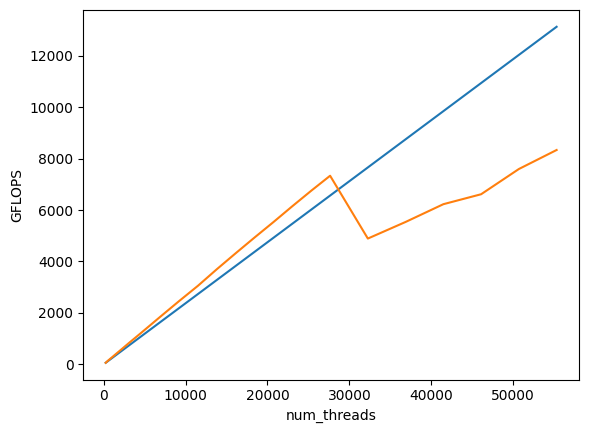

In [239]:
import matplotlib.pyplot as plt

DATA = r"""
256 60.761 GFLOPS
512 136.759 GFLOPS
768 205.410 GFLOPS
1024 273.127 GFLOPS
1536 411.445 GFLOPS
2304 616.603 GFLOPS
3072 824.166 GFLOPS
4608 1230.754 GFLOPS
6912 1848.764 GFLOPS
9216 2459.781 GFLOPS
11520 3055.546 GFLOPS
13824 3699.190 GFLOPS
16128 4321.098 GFLOPS
18432 4932.755 GFLOPS
20736 5532.676 GFLOPS
23040 6148.738 GFLOPS
25344 6750.046 GFLOPS
27648 7332.850 GFLOPS
32256 4890.845 GFLOPS
36864 5536.332 GFLOPS
41472 6226.503 GFLOPS
46080 6613.525 GFLOPS
50688 7594.311 GFLOPS
55296 8333.710 GFLOPS
"""

def main():
    data = DATA.strip().split("\n")
    X = []
    Y = []
    L = []
    for line in data:
        fields = line.strip().split()
        if len(fields) != 3:
            continue
        x, y = fields[:2]
        X.append(float(x))
        Y.append(float(y))
        L.append(Y[0] / X[0] * float(x))
    plt.ylabel("GFLOPS")
    plt.xlabel("num_threads")
    plt.plot(X, L)
    plt.plot(X, Y)
    plt.show()

main()